In [1]:
####importing packages
import sys
sys.path.append('/work/mh0731/m300876/package')
import interp3d
import icons
from pathlib import Path
import importlib
import numpy as np
import xarray as xr
from distributed import Client, progress, wait # Libaray to orchestrate distributed resources\

/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
import dask # Distributed data libary

In [3]:
icons.prepare_cpu(memory='128GB',nworker=1)

Number of CPUs: 256, number of threads: 256, number of workers: 1, processes: False


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/m300876/levante-spawner-advanced//proxy/36105/status,
Dashboard: /user/m300876/levante-spawner-advanced//proxy/36105/status,Workers: 1
Total threads: 256,Total memory: 119.21 GiB
Status: running,Using processes: False
Comm: inproc://136.172.120.208/582563/1,Workers: 1
Dashboard: /user/m300876/levante-spawner-advanced//proxy/36105/status,Total threads: 256
Started: Just now,Total memory: 119.21 GiB
Comm: inproc://136.172.120.208/582563/4,Total threads: 256
Dashboard: /user/m300876/levante-spawner-advanced//proxy/35347/status,Memory: 119.21 GiB
Nanny: None,


**Interpolate data**

In [4]:
def add_coord_var(darray,gridset):
    clon_x = xr.DataArray(gridset.clon.values,
                      dims=gridset.clon.dims,attrs={k:v for k,v in gridset.clon.attrs.items()})
    clat_y = xr.DataArray(gridset.clat.values,
                      dims=gridset.clat.dims,attrs={k:v for k,v in gridset.clat.attrs.items()})
    dset = darray.rename({'ncells':'cell'}).assign_coords(clon=clon_x,clat=clat_y).to_dataset()
    dset['clon_vertices'] = gridset.clon_vertices 
    dset['clat_vertices'] = gridset.clat_vertices 
    return dset

In [5]:
def cut_gridset(grid_file,x_first,y_first,x_end,y_end):
    gridset = xr.open_dataset(grid_file,chunks='auto')
    factor = 1/180*np.pi
    return gridset.where(((gridset.clon>(x_first*factor)) & (gridset.clon<(x_end*factor))) & (
        (gridset.clat>(y_first*factor)) & (gridset.clat<(y_end*factor))),drop=True) 

In [6]:
def interp_data(darray, x_res, y_res,x_first,y_first,x_end,y_end,grid_file,weights=None):
    gridset = cut_gridset(grid_file,x_first,y_first,x_end,y_end)
    dset= add_coord_var(darray,gridset)
    ###interpolation
    remap_var = interp3d.remap_cut(dset, x_res, y_res,x_first,y_first,x_end,y_end,grid_file)
    remap_jobs = dask.persist(remap_var)
    progress(remap_jobs, notebook=False)
    var_final = dask.compute(remap_var)
    return var_final[0]

**ngc2002**

In [7]:
#Define a global pattern to find the files
###cloud liquid water 
glob_pattern_3d1 = 'atm_2d_ml'
## Define the paths of file 1 (dppp0016)
data_path1 = Path('/work/mh0731/m300948/nextgems_cycle2_2/experiments/DEF100/work')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
files02 = sorted([str(f) for f in data_path1.glob(f'run*/*{glob_pattern_3d1}*.nc')])[:]

In [8]:
ctl_2d_list = []
files = sorted([str(f) for f in data_path1.glob(f'run*/*atm_2d_ml*')],reverse=True)[:]

for f in files:
    if str(f)[-19:-3] not in [str(t)[-19:-3] for t in ctl_2d_list]:

#if str(f)[-19:-3] for f in files not in str(t)[-19:-3] for t in ctl_2d_list:
#        print(str(f)[-19:-3])
        ctl_2d_list.append(str(f))

filesnew = sorted(ctl_2d_list)

In [9]:
grid_file = '/pool/data/ICON/grids/public/mpim/0015/icon_grid_0015_R02B09_G.nc'

__netcdf4__

In [10]:
%time vas01 = icons.spatial_mean(filesnew,'netcdf','vas',['2020-03-01','2020-03-31'],[-20,10],\
                                 [-85,-35],mask=1,better_time=False)

CPU times: user 3min 6s, sys: 1min 38s, total: 4min 45seted |  4min  4.1s
Wall time: 5min 12s


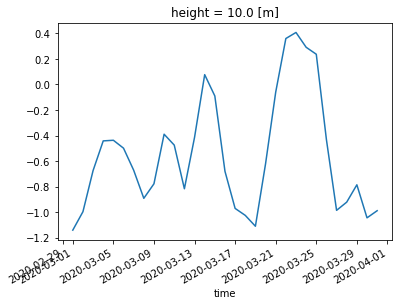

In [12]:
vas01.plot()